In [0]:
# This is the code for training the models on text datasets using embedding matrix
# To test the code, run the last 4 cells after loading the model files in the colab environment ie. the cells starting right after the references cell
#set dataset variable to 0 for imdb dataset and 1 for news dataset
# It will give graphs, accuracy and confusion matrix for the 3 models
# To train models again, run all cells from the top

In [0]:

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,Conv1D,LSTM,SimpleRNN,Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [39]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [40]:
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

In [0]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [0]:
dataset = 0
if dataset == 0:
  modDfObj = pd.read_csv("IMDB Dataset.csv")
if dataset ==1:
  modDfObj = pd.read_csv("NewsDataTop15.csv")

In [0]:
if dataset == 0:
  sentences = list(modDfObj['review'])
if dataset == 1:
  sentences = list(modDfObj['Text'])

X = []
for sentence in sentences:
  TAG_RE = re.compile(r'<[^>]+>')
  sentence = TAG_RE.sub('',sentence) 
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  word_tokens = word_tokenize(sentence) 
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  X.append(filtered_sentence)

In [0]:
if dataset == 0:
  y = modDfObj['sentiment']
  y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
if dataset == 1:
  y = modDfObj['Label']

In [0]:
maxlen = 100

tokenizer = Tokenizer(num_words=7500)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25)

In [47]:
 vocabulary_size = len(tokenizer.word_index) + 1
 print(vocabulary_size)

37722


In [0]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector


In [0]:
def build_CNN(vocabulary_size,maxlen):
  model = Sequential()
  #model.add(Embedding(vocabulary_size, 100, input_length=maxlen))
  embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  model.add(Conv1D(128, 5, activation='relu'))  
  model.add(Conv1D(64, 5, activation='relu'))
  model.add(Conv1D(32, 5, activation='relu'))
  model.add(SeqSelfAttention(attention_activation='sigmoid'))
  model.add(Flatten()) 
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [50]:
CNNmodel= build_CNN(vocabulary_size,maxlen)
CNNmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          3772200   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 64)            41024     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 88, 32)            10272     
_________________________________________________________________
seq_self_attention_2 (SeqSel (None, 88, 32)            2113      
_________________________________________________________________
flatten_2 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [51]:
history = CNNmodel.fit(X_train, y_train, batch_size=85, epochs=3, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/3
1431/1431 [==============================] - 4s 3ms/step - loss: 0.6989 - acc: 0.5276 - val_loss: 0.6909 - val_acc: 0.6000
Epoch 2/3
1431/1431 [==============================] - 0s 143us/step - loss: 0.6920 - acc: 0.5297 - val_loss: 0.6889 - val_acc: 0.6000
Epoch 3/3
1431/1431 [==============================] - 0s 129us/step - loss: 0.6927 - acc: 0.5297 - val_loss: 0.6901 - val_acc: 0.6000


In [52]:
score = CNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 0s 102us/step
Test Score: 0.692327514066169
Test Accuracy: 0.5301507543678858


In [53]:
y_pred = CNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[  0,   0],
       [187, 211]])

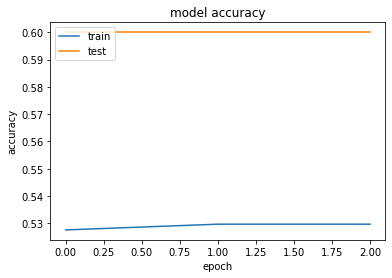

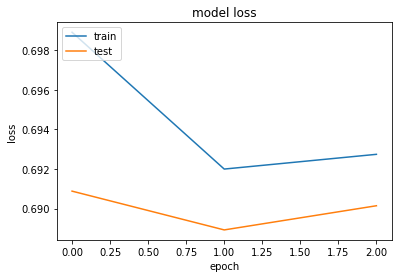

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
def build_LSTM(vocabulary_size,maxlen):
  model = Sequential()
  embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  #model.add(Embedding(vocabulary_size, 128, input_length=maxlen))
  model.add(Bidirectional(LSTM(64,return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  #model.add(SeqSelfAttention(attention_activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [56]:
LSTMmodel= build_LSTM(vocabulary_size,maxlen)
LSTMmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3772200   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 3,897,961
Trainable params: 125,761
Non-trainable params: 3,772,200
_________________________________________________________________


In [57]:
history = LSTMmodel.fit(X_train, y_train, batch_size=85, epochs=3, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/3
1431/1431 [==============================] - 16s 11ms/step - loss: 0.7024 - acc: 0.5087 - val_loss: 0.7005 - val_acc: 0.4938
Epoch 2/3
1431/1431 [==============================] - 11s 8ms/step - loss: 0.6971 - acc: 0.5192 - val_loss: 0.6906 - val_acc: 0.5188
Epoch 3/3
1431/1431 [==============================] - 11s 8ms/step - loss: 0.6888 - acc: 0.5381 - val_loss: 0.6795 - val_acc: 0.6000


In [58]:
score = LSTMmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 3s 8ms/step
Test Score: 0.6929660068085445
Test Accuracy: 0.5301507543678858


In [59]:
y_pred = LSTMmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[  0,   0],
       [187, 211]])

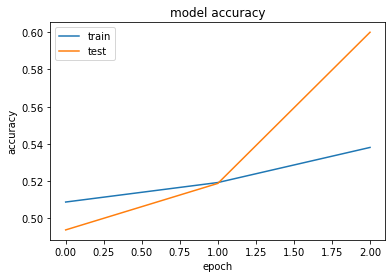

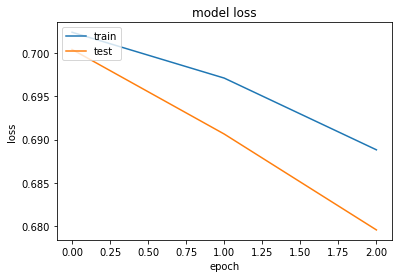

In [60]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
def build_RNN(vocabulary_size,maxlen):
  model = Sequential()
 # embedding_layer = Embedding(vocabulary_size, 100, input_length=maxlen , trainable=False)
  #model.add(embedding_layer)
  embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  model.add(Bidirectional(SimpleRNN(128, activation='relu',return_sequences=True)))
  model.add(Bidirectional(SimpleRNN(32, activation='relu')))
  #model.add(SeqSelfAttention(attention_activation='sigmoid'))
  model.add(Dense(16,activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

In [62]:
RNNmodel= build_RNN(vocabulary_size,maxlen)
RNNmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3772200   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 256)          58624     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                18496     
_________________________________________________________________
dense_7 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 3,850,377
Trainable params: 78,177
Non-trainable params: 3,772,200
_________________________________________________________________


In [63]:
history = RNNmodel.fit(X_train, y_train, batch_size=85, epochs=7, verbose=1, validation_split=0.1)

Train on 1431 samples, validate on 160 samples
Epoch 1/7
1431/1431 [==============================] - 8s 6ms/step - loss: 0.7254 - acc: 0.5115 - val_loss: 0.6935 - val_acc: 0.4438
Epoch 2/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6806 - acc: 0.5744 - val_loss: 0.6889 - val_acc: 0.5375
Epoch 3/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6558 - acc: 0.6171 - val_loss: 0.6947 - val_acc: 0.5375
Epoch 4/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.6156 - acc: 0.6751 - val_loss: 0.7063 - val_acc: 0.5000
Epoch 5/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.5413 - acc: 0.7743 - val_loss: 0.7547 - val_acc: 0.5125
Epoch 6/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.4419 - acc: 0.8407 - val_loss: 0.8220 - val_acc: 0.4688
Epoch 7/7
1431/1431 [==============================] - 3s 2ms/step - loss: 0.3098 - acc: 0.9119 - val_loss: 0.8214 - val_acc: 0.5250


In [64]:
score = RNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

398/398 [==============================] - 1s 3ms/step
Test Score: 0.9889023357899345
Test Accuracy: 0.47236180919498655


In [65]:
y_pred = RNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
confusion_matrix(y_pred,y_test)

array([[ 82, 105],
       [105, 106]])

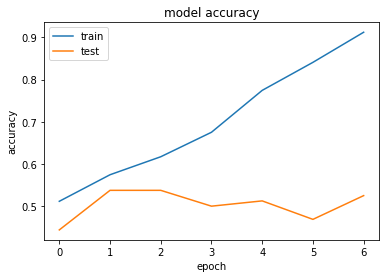

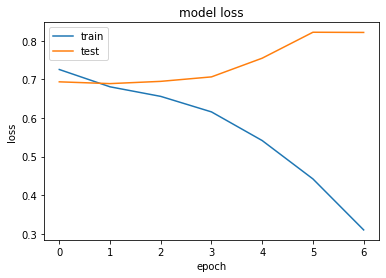

In [66]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [0]:
word_index= tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
e = CNNmodel.layers[0]
weights = e.get_weights()[0]

In [0]:
#creating vector files that can be loaded to tensorflow website to check embeddings
import io

out_v = io.open('vecsenews'+str(dataset)+'.tsv', 'w', encoding='utf-8')
out_m = io.open('metaenews'+str(dataset)+'.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocabulary_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [0]:
RNNmodel.save('rnn_with_embed_news.h5')
CNNmodel.save('cnn_with_embed_news.h5')
LSTMmodel.save('lstm_with_embed_news.h5')

In [0]:
# References:
#https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://keras.io/examples/imdb_bidirectional_lstm/
# https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/AXwJI/implementing-lstms-in-code
# https://www.coursera.org/learn/natural-language-processing-tensorflow/lecture/Sydkf/notebook-for-lesson-2
# https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
# https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e
# https://medium.com/@Petuum/embeddings-a-matrix-of-meaning-4de877c9aa27
#https://github.com/tensorflow/tensorflow/issues/23698
#https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/-
# https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%202%20-%20Lesson%201.ipynb
#https://jovianlin.io/saving-loading-keras-models/

In [71]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import re
import nltk
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten,Conv1D,LSTM,SimpleRNN, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model
import nltk
nltk.download('all')
!pip install keras-self-attention
from keras_self_attention import SeqSelfAttention

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

398/398 [==============================] - 2s 4ms/step
Test Score: 0.692327514066169
Test Accuracy: 0.5301507543678858
[[  0   0]
 [187 211]]


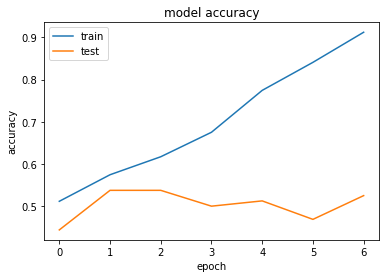

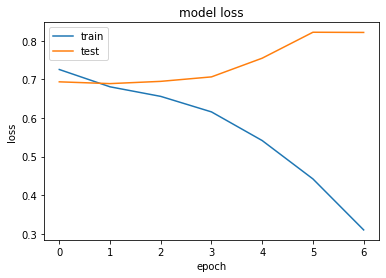

In [72]:
CNNmodel = load_model('cnn_with_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = CNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = CNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

398/398 [==============================] - 5s 13ms/step
Test Score: 0.6929660068085445
Test Accuracy: 0.5301507543678858
[[  0   0]
 [187 211]]


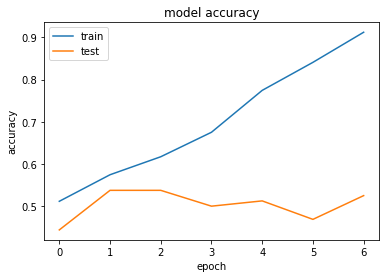

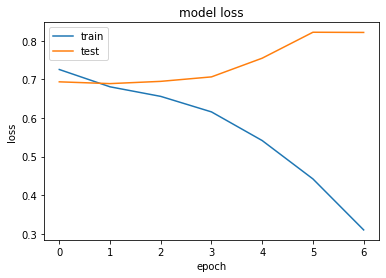

In [73]:
LSTMmodel = load_model('lstm_with_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = LSTMmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = LSTMmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

398/398 [==============================] - 3s 8ms/step
Test Score: 0.9889023357899345
Test Accuracy: 0.47236180919498655
[[ 82 105]
 [105 106]]


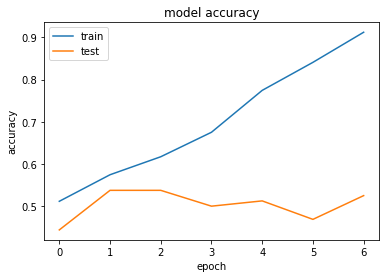

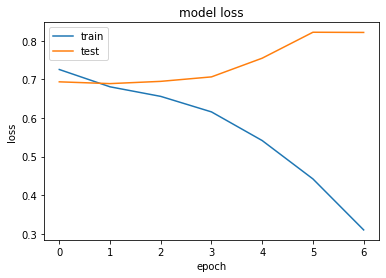

In [74]:
RNNmodel = load_model('rnn_with_embed_news.h5', custom_objects = {'SeqSelfAttention':SeqSelfAttention})
score = RNNmodel.evaluate(X_test,y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
y_pred = RNNmodel.predict(X_test)
y_pred=np.rint(y_pred)
print(confusion_matrix(y_pred,y_test))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()